In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
inputdir = "../../data/derived/"

In [3]:
#Import the data
data17 = pd.read_csv(inputdir + "chfs2017data.csv")
data15 = pd.read_csv(inputdir + "chfs2015data.csv")
data13 = pd.read_csv(inputdir + "chfs2013data.csv")
data11 = pd.read_csv(inputdir + "chfs2011data.csv")

In [4]:
data17.head()

,hhid,hhid_2011,hhid_2013,hhid_2015,hhid_2017,stock_investment,stock_investment_scope,pline,hhead,education_level,...,married,stock_account,health,own_house,happiness,rural_household_registration,credit_constraints,financial_literacy,risk_preference,IV
0,201103890,201103890.0,2.013012e+09,2.015016e+09,2017012829,NaN,NaN,1,NaN,1.0,...,1,0.0,1.0,1,1.0,1,0,NaN,NaN,0.083333
1,2017023389,NaN,NaN,NaN,2017023389,NaN,NaN,4,NaN,7.0,...,0,0.0,4.0,1,1.0,1,0,3.0,2.0,0.083333
2,201103892,201103892.0,2.013012e+09,2.015016e+09,2017016487,NaN,NaN,3,NaN,6.0,...,0,0.0,1.0,1,1.0,1,0,NaN,NaN,0.083333
3,201103892,201103892.0,2.013012e+09,2.015016e+09,2017016487,NaN,NaN,1,1.0,2.0,...,1,0.0,3.0,1,1.0,1,0,NaN,NaN,0.083333
4,2013011929,NaN,2.013012e+09,2.015016e+09,2017007331,NaN,NaN,1,1.0,3.0,...,1,0.0,0.0,1,1.0,1,1,NaN,NaN,0.079861


# Data cleaning

<AxesSubplot:>

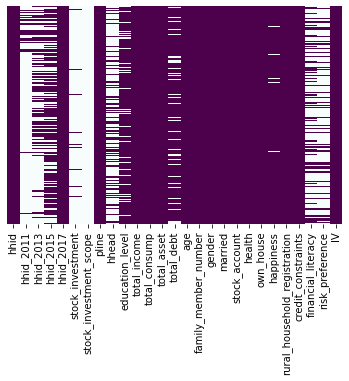

In [5]:
#Data visualization for the missing values
sns.heatmap(data17.isnull(), yticklabels=False, cbar=False, cmap='BuPu_r')

In [6]:
data17.isna().sum()

hhid                                 0
hhid_2011                       110864
hhid_2013                        70872
hhid_2015                        38868
hhid_2017                            0
stock_investment                120378
stock_investment_scope          126351
pline                                0
hhead                            87001
education_level                  17948
total_income                         0
total_consump                        0
total_asset                          0
total_debt                       18867
age                                 47
family_member_number                11
gender                               8
married                              0
stock_account                      385
health                              88
own_house                            0
happiness                         1415
rural_household_registration         0
credit_constraints                   0
financial_literacy               88124
risk_preference          

In [7]:
#Row numbers for chfs 2017 data
data17.shape[0]

127012

**Deal with missing values of stock-related variables**

In [8]:
data17["stock_investment"] = np.where(data17["stock_account"] == 0, 0, data17["stock_investment"])

In [9]:
data17["stock_investment"] = np.where((data17["stock_investment"] == ".d") | 
                                      (data17["stock_investment"] == ".r") |
                                      (data17["stock_investment"] == ".n"), 
                                      ".", data17["stock_investment"])
data17["stock_investment"] = np.where(data17["stock_investment"] == ".", -1, data17["stock_investment"])
data17["stock_investment"] = data17["stock_investment"].astype(float)

In [10]:
data17["stock_investment_scope"] = np.where(data17["stock_investment"] == 0, 
                                            0, data17["stock_investment_scope"])
data17["stock_investment_scope"] = np.where((data17["stock_investment"] > 0) & 
                                            (data17["stock_investment"] < 10000), 
                                            1, data17["stock_investment_scope"])
data17["stock_investment_scope"] = np.where((data17["stock_investment"] >= 10000) & 
                                            (data17["stock_investment"] < 30000),
                                            2, data17["stock_investment_scope"])
data17["stock_investment_scope"] = np.where((data17["stock_investment"] >= 30000) & 
                                            (data17["stock_investment"] < 50000),
                                            3, data17["stock_investment_scope"])
data17["stock_investment_scope"] = np.where((data17["stock_investment"] >= 50000) & 
                                            (data17["stock_investment"] < 70000),
                                            4, data17["stock_investment_scope"])
data17["stock_investment_scope"] = np.where((data17["stock_investment"] >= 70000) & 
                                            (data17["stock_investment"] < 100000),
                                            5, data17["stock_investment_scope"])
data17["stock_investment_scope"] = np.where((data17["stock_investment"] >= 100000) & 
                                            (data17["stock_investment"] < 300000),
                                            6, data17["stock_investment_scope"])
data17["stock_investment_scope"] = np.where((data17["stock_investment"] >= 300000) & 
                                            (data17["stock_investment"] < 500000),
                                            7, data17["stock_investment_scope"])
data17["stock_investment_scope"] = np.where((data17["stock_investment"] >= 500000) & 
                                            (data17["stock_investment"] < 1000000),
                                            8, data17["stock_investment_scope"])
data17["stock_investment_scope"] = np.where((data17["stock_investment"] >= 1000000) & 
                                            (data17["stock_investment"] < 5000000),
                                            9, data17["stock_investment_scope"])
data17["stock_investment_scope"] = np.where((data17["stock_investment"] >= 5000000) & 
                                            (data17["stock_investment"] < 10000000),
                                            10, data17["stock_investment_scope"])
data17["stock_investment_scope"] = np.where(data17["stock_investment"] >= 10000000,
                                            11, data17["stock_investment_scope"])

In [11]:
#Delete unneeded variables
del data17["stock_account"]
del data17["stock_investment"]

In [12]:
#Rename the following variables
data17.rename(columns = {'stock_investment_scope':'stock_investment'}, inplace = True)

In [13]:
#Since my research question is focused on the household level, I only need one data per household.
#That is, the data of the head of the household.
data17 = data17.dropna(subset = ['hhead'])
del data17['hhead']

In [14]:
data15.head()

,hhid_2015,financial_literacy_2015,risk_preference_2015
0,2015000001,1.0,0.0
1,2015000002,3.0,2.0
2,2015000003,1.0,0.0
3,2015000004,3.0,4.0
4,2015000005,0.0,0.0


In [15]:
data13.head()

,hhid_2013,financial_literacy_2013,risk_preference_2013
0,2013000001,1.0,1.0
1,2013000002,2.0,1.0
2,2013000003,2.0,0.0
3,2013000004,3.0,0.0
4,2013000005,2.0,2.0


In [16]:
data11.head()

,hhid_2011,risk_preference_2011
0,201100001,0.0
1,201100002,0.0
2,201100003,0.0
3,201100004,0.0
4,201100005,0.0


In [17]:
data17['hhid_2015'] = np.where(data17["hhid_2015"].isnull() == True, -1, data17["hhid_2015"])
data17['hhid_2013'] = np.where(data17["hhid_2013"].isnull() == True, -1, data17["hhid_2013"])
data17['hhid_2011'] = np.where(data17["hhid_2011"].isnull() == True, -1, data17["hhid_2011"])
data17['hhid_2015'] = data17['hhid_2015'].astype(int)
data17['hhid_2013'] = data17['hhid_2013'].astype(int)
data17['hhid_2011'] = data17['hhid_2011'].astype(int)

You can observe a large number of missing values in `financial_literacy` and `risk_preference` in data17 because only new respondents were interviewed in these two related questions in the 2017 survey. Therefore, I need to merge the previous data and fill in the missing values.

In [18]:
data1 = pd.merge(data17, data15, on = 'hhid_2015', how = 'outer')
data2 = pd.merge(data1, data13, on = 'hhid_2013', how = 'outer')
data = pd.merge(data2, data11, on = 'hhid_2011', how = 'outer')
#The merge method I used produces a lot of na values, remove them.
data = data.dropna(subset = ['hhid'])
#The merge method I used also produces a lot of duplicate values, so I need to remove these duplicates.
data = data.drop_duplicates(subset = ['hhid'], keep = 'first')

In [19]:
data['financial_literacy'] = np.where(data["financial_literacy"].isnull() == True, 
                                      data["financial_literacy_2015"], data["financial_literacy"])
data['financial_literacy'] = np.where(data["financial_literacy"].isnull() == True, 
                                      data["financial_literacy_2013"], data["financial_literacy"])

In [20]:
data['risk_preference'] = np.where(data["risk_preference"].isnull() == True, data["risk_preference_2015"], 
                                   data["risk_preference"])
data['risk_preference'] = np.where(data["risk_preference"].isnull() == True, data["risk_preference_2013"], 
                                   data["risk_preference"])
data['risk_preference'] = np.where(data["risk_preference"].isnull() == True, data["risk_preference_2011"], 
                                   data["risk_preference"])

In [21]:
#Delete unneeded variables
del data["hhid_2017"]
del data["hhid_2015"]
del data["hhid_2013"]
del data["hhid_2011"]
del data["financial_literacy_2015"]
del data["financial_literacy_2013"]
del data["risk_preference_2015"]
del data["risk_preference_2013"]
del data["risk_preference_2011"]

In [22]:
data.isna().sum()

hhid                               0
stock_investment                1264
pline                              0
education_level                   53
total_income                       0
total_consump                      0
total_asset                        0
total_debt                      8337
age                               11
family_member_number               3
gender                             1
married                            0
health                             9
own_house                          0
happiness                        458
rural_household_registration       0
credit_constraints                 0
financial_literacy                46
risk_preference                 3692
IV                                 0
dtype: int64

<AxesSubplot:>

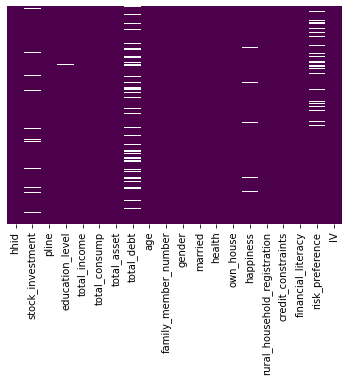

In [23]:
#Data visualization for the missing values
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='BuPu_r')

In [24]:
#Delete rows with too many missing values
data = data.dropna(subset = ['total_debt'])
data = data.dropna(subset = ['risk_preference'])
data = data.dropna(subset = ['stock_investment'])
data = data.dropna(subset = ['happiness'])

In [25]:
data.isna().sum()

hhid                             0
stock_investment                 0
pline                            0
education_level                 37
total_income                     0
total_consump                    0
total_asset                      0
total_debt                       0
age                              7
family_member_number             3
gender                           0
married                          0
health                           7
own_house                        0
happiness                        0
rural_household_registration     0
credit_constraints               0
financial_literacy              11
risk_preference                  0
IV                               0
dtype: int64

In [26]:
#Continue processing the missing values
data['education_level'] = data['education_level'].fillna(data['education_level'].median())
data['health'] = data['health'].fillna(data['health'].median())
data['family_member_number'] = data['family_member_number'].fillna(data['family_member_number'].median())
data['age'] = data['age'].fillna(data['age'].mean())
data['financial_literacy'] = data['financial_literacy'].fillna(data['financial_literacy'].median())

In [27]:
#The following variables contain `.d` | `.r` | `.e` in their values, remove them
data = data.drop(data[data['stock_investment'] == '.d'].index)
data = data.drop(data[data['stock_investment'] == '.r'].index)
data = data.drop(data[data['stock_investment'] == '.e'].index)

<AxesSubplot:>

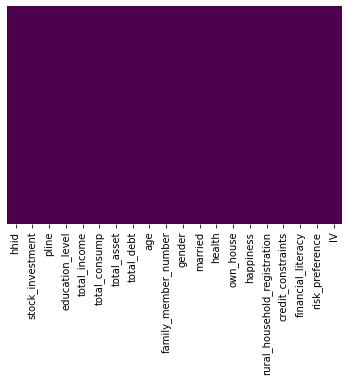

In [28]:
#All missing values have been processed
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='BuPu_r')

In [29]:
data.describe()

,hhid,pline,education_level,total_income,total_consump,total_asset,total_debt,age,family_member_number,gender,married,health,own_house,happiness,rural_household_registration,credit_constraints,financial_literacy,risk_preference,IV
count,2.769800e+04,27698.000000,27698.000000,2.769800e+04,2.769800e+04,2.769800e+04,2.769800e+04,27698.000000,27698.000000,27698.000000,27698.000000,27698.000000,27698.000000,27698.000000,27698.000000,27698.000000,27698.000000,27698.000000,27698.000000
mean,1.767226e+09,1.560582,3.470648,1.019716e+05,6.854908e+04,1.157742e+06,7.339570e+04,52.659034,3.941584,0.173081,0.889017,2.449202,0.923893,0.702433,0.565745,0.080475,1.046682,1.263737,0.078927
std,6.228038e+08,0.984129,1.642670,2.182731e+05,8.415257e+04,2.224913e+06,3.154492e+05,12.966156,2.279821,0.378324,0.314116,1.004360,0.265173,0.457196,0.495668,0.272032,1.095086,1.322639,0.065657
min,2.011000e+08,1.000000,1.000000,-4.950324e+06,7.368000e+02,-2.124020e+05,0.000000e+00,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.013010e+09,1.000000,2.000000,2.602125e+04,2.803400e+04,1.404178e+05,0.000000e+00,44.000000,2.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028090
50%,2.015004e+09,1.000000,3.000000,6.147750e+04,4.909000e+04,4.329470e+05,0.000000e+00,52.000000,3.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.057252
75%,2.017005e+09,2.000000,4.000000,1.146328e+05,8.127675e+04,1.154978e+06,3.300000e+04,62.000000,5.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.107612
max,2.017040e+09,20.000000,9.000000,8.497832e+06,3.434645e+06,6.394004e+07,2.023763e+07,117.000000,30.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,5.000000,0.330909


In [30]:
len(data)

27698

In [31]:
#Export data
data.to_csv(inputdir + 'processed_chfs_data.csv', index=False)